In [1]:
import numpy as np
import sympy, scipy, cmath
from sympy import *
#from sympy import symbols
#from sympy.solvers.solveset import nonlinsolve
from scipy import sparse as sp
#from scipy import linalg as ln
from scipy import optimize as opt
from scipy.sparse import  coo_matrix as cmm
from matplotlib import pyplot as pp

In [16]:
#Parameters
#default values: mu=1.8 m=.5 t=3 alR=.7 B=3.07 delta=.5 phi=Pi

kx=0.

mu=1.8
m=.5
t=3
alR=2.
#B=3.07
delta=.5
#phi=np.pi

def mut(kx):
    return mu-2*t-kx**2/(2*m)-alR**2*m/2
def kF(mu):
    return cmath.sqrt(2*m*mu)
def a(t):
    return 1/cmath.sqrt(2*m*t)

def delL(phi):
    return delta*cmath.exp(1j*phi/2)
def delR(phi):
    return delta*cmath.exp(-1j*phi/2)
def nu0(m):
    return m/(2*np.pi)
def xiE(En):
    return kF(mu)/(m*cmath.sqrt(delta**2-En**2))

tL=2
tR=tL

NJ=1


#matrix tools
eye2=np.eye(2)
eye4=np.eye(4)
s1=[[0,1],[1,0]]
s2=[[0,-1j],[1j,0]]
s3=[[1,0],[0,-1]]
tP=np.kron([[0,1],[0,0]],eye2)
tM=np.kron([[0,0],[1,0]],eye2)
t3=np.kron(s3,eye2)

In [17]:
#Junction
def HJ0(kx,B):
    return -mut(kx)*t3+alR*kx*np.kron(s3,s2)+B*np.kron(eye2,s1)
def Hy(alR):
    return -t*t3+1j*alR/2/a(t)*np.kron(s3,s1)


def HJ(kx,B):
    start=cmm(HJ0(kx,B))
    HJs=start
    for n in range(0,NJ-1):
        OT=cmm(np.zeros([len(HJs.toarray())-4,4]))
        BT=sp.vstack([OT,cmm(Hy(alR))])
        CT=sp.hstack([OT.transpose(),cmm(Hy(alR).conj().T),start])
        HJs=sp.hstack([HJs,BT])
        HJs=sp.vstack([HJs,CT])
    return HJs

def gJm1(En,kx,B):
    return En*np.eye(4*NJ)-HJ(kx,B).toarray()

#Superconductors
# xiE-> infty to avoid more symbolic:
#def fL(kx):
#    return 1/(kF*a)*(np.log(1-np.exp(1j*a*(kF+kx)))+np.log(1-np.exp(1j*a*(kF-kx))))-1j

def fL(En,kx):
    return 1/(kF(mu)*a(t))*(cmath.log(1-cmath.exp(-a(t)/xiE(En)+1j*a(t)*(kF(mu)+kx)))+\
                         cmath.log(1-cmath.exp(-a(t)/xiE(En)+1j*a(t)*(kF(mu)-kx))))-1j

def gSC1m1(En,kx,phi):
    return -1/(np.pi*nu0(m)*abs(fL(En,kx))**2)*((En*eye4 - delL(phi)*tP - np.conj(delL(phi))*tM)*\
                                                 fL(En,kx).imag/cmath.sqrt(delta**2 - En**2) - fL(En,kx).real*t3)

def gSC2m1(En,kx,phi):
    return -1/(np.pi*nu0(m)*abs(fL(En,kx))**2)*((En*eye4 - delR(phi)*tP - np.conj(delR(phi))*tM)*\
                                                 fL(En,kx).imag/cmath.sqrt(delta**2 - En**2) - fL(En,kx).real*t3)

#SC/J coupling
rowindex=np.array([1,2,3,4,4*NJ+1,4*NJ+2,4*NJ+3,4*NJ+4])-1
colindex=np.array([5,6,7,8,4*(NJ+1)+1,4*(NJ+1)+2,4*(NJ+1)+3,4*(NJ+1)+4])-1
hoppings=[tL,tL,-tL,-tL,tR,tR,-tR,-tR]
mHt1=cmm((hoppings,(rowindex,colindex)),shape=(4*(NJ+2),4*(NJ+2)))
mHt=mHt1+mHt1.transpose()

#total inverse GF
def Gtotm1(En,kx,phi,B):
    return scipy.linalg.block_diag(gSC1m1(En,kx,phi),gJm1(En,kx,B),gSC2m1(En,kx,phi))+mHt.toarray()

In [18]:
M=100
phiarray=np.linspace(0*np.pi,2.*np.pi,M+1)

In [21]:
PDtr=np.zeros((M+1,NJ))#2*NJ))

En=0

for qq in range(M+1):
    phi=phiarray[qq]
    print(qq)
    ekxphi=[]
    def fdetB(B):
        return np.linalg.det(Gtotm1(En,kx,phi,B))/(mu**(4.*(NJ+0)))
    x0roots=np.ndarray.tolist(np.linspace(0,10,12))
    for i in range(len(x0roots)):
        x0=x0roots[i]
        solekx=opt.fsolve(fdetB,np.asarray(x0))
        if abs(fdetB(solekx))>10**-6 or solekx<0:# or solekx>2*np.pi+0.1
            solekx=[]
        solekx=np.ndarray.tolist(np.around(solekx,4))
        ekxphi.extend(solekx)
    ekxphi=np.sort(list(set(ekxphi)))
    print(ekxphi)
    if len(ekxphi)<NJ: ###here 2*
        zerocompletion=[0]*(NJ-len(ekxphi)) ###here
        ekxphi.extend(zerocompletion)
    elif len(ekxphi)>NJ:  ###here
        print("Too many roots.")
        break
    PDtr[qq]=np.asarray(ekxphi)

0
[8.2286]
1
[8.2253]
2
[8.2153]
3
[8.1988]
4
[8.1756]
5
[8.146]
6
[8.1098]
7
[8.0672]
8
[8.0181]
9
[7.9628]
10
[7.9013]
11
[7.8337]
12
[7.76]
13
[7.6805]
14
[7.5952]
15
[7.5044]
16
[7.4081]
17
[7.3065]
18
[7.1998]
19
[7.0883]
20
[6.9721]
21
[6.8515]
22
[6.7267]
23
[6.598]
24
[6.4657]
25


KeyboardInterrupt: 

In [22]:
MB=100
Blist=np.linspace(0,10,MB+1)
print(Blist)

PDgap=np.ones((len(phiarray),len(Blist)))

[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7
  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1
  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5
  5.6  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9
  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3
  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7
  9.8  9.9 10. ]


In [23]:
Etest=0
LE=200 #E decimation
listEn=np.ndarray.tolist(np.linspace(0,delta,LE+1))

kmin=-np.pi
kmax=0.1
x0roots=np.linspace(kmin,kmax,10)#np.int((kmax-kmin)/.3))

for qq in range(M+1):
    phi=phiarray[qq]
    print('{}) phi={}'.format(qq,phi))
    
    bind=0
    Bstar=Blist.max()#PDtr[qq,bind]
    for tp in range(MB+1):
        B=Blist[tp]
        print('{}.{}) B={}'.format(qq,tp,B))
        if B<Bstar and Bstar<Blist[tp+1]:
            En=0.
            bind+=1
            if bind<NJ:
                Bstar=PDtr[qq,bind]
            else:
                Bstar=Blist.max()
        else:
            for En in listEn:
                def fdetkx(kxx):
                    return np.linalg.det(Gtotm1(En,kxx,phi,B))/(mu**(8*(NJ+2)))
                for go in range(len(x0roots)):
                    solveEKX=opt.fsolve(fdetkx,[x0roots[go]])
                    if abs(fdetkx(solveEKX))<10**-6:# and abs(solveEKX)<=kF:
                        print("found")
                        Etest=1
                        break
                if Etest==1:
                    break
        print('gap={}'.format(En))
        PDgap[qq,tp]=En
        Etest=0
            

0) phi=0.0
0.0) B=0.0
found
gap=0.4025
0.1) B=0.1
found
gap=0.4025
0.2) B=0.2
found
gap=0.4025
0.3) B=0.3
found
gap=0.4
0.4) B=0.4
found
gap=0.4
0.5) B=0.5
found
gap=0.3975
0.6) B=0.6
found
gap=0.395
0.7) B=0.7
found
gap=0.3925
0.8) B=0.8
found
gap=0.3875
0.9) B=0.9
found
gap=0.385
0.10) B=1.0
found
gap=0.38
0.11) B=1.1
found
gap=0.3775
0.12) B=1.2
found
gap=0.3725
0.13) B=1.3
found
gap=0.3675
0.14) B=1.4
found
gap=0.3625
0.15) B=1.5
found
gap=0.3575
0.16) B=1.6
found
gap=0.3525
0.17) B=1.7
found
gap=0.3475
0.18) B=1.8
found
gap=0.34
0.19) B=1.9
found
gap=0.335
0.20) B=2.0
found
gap=0.33
0.21) B=2.1
found
gap=0.325
0.22) B=2.2
found
gap=0.3175
0.23) B=2.3
found
gap=0.3125
0.24) B=2.4
found
gap=0.3075
0.25) B=2.5
found
gap=0.3
0.26) B=2.6
found
gap=0.295
0.27) B=2.7
found
gap=0.29
0.28) B=2.8
found
gap=0.285
0.29) B=2.9
found
gap=0.2775
0.30) B=3.0
found
gap=0.2725
0.31) B=3.1
found
gap=0.2675
0.32) B=3.2
found
gap=0.2625
0.33) B=3.3
found
gap=0.2575
0.34) B=3.4
found
gap=0.2525
0.35) B

found
gap=0.03
2.88) B=8.8
found
gap=0.0375
2.89) B=8.9
found
gap=0.0425
2.90) B=9.0
found
gap=0.0475
2.91) B=9.1
found
gap=0.055
2.92) B=9.2
found
gap=0.06
2.93) B=9.3
found
gap=0.065
2.94) B=9.4
found
gap=0.07
2.95) B=9.5
found
gap=0.075
2.96) B=9.6
found
gap=0.0825
2.97) B=9.7
found
gap=0.0875
2.98) B=9.8
found
gap=0.0925
2.99) B=9.9
found
gap=0.0975
2.100) B=10.0
found
gap=0.0925
3) phi=0.188495559215
3.0) B=0.0
found
gap=0.4
3.1) B=0.1
found
gap=0.4
3.2) B=0.2
found
gap=0.4
3.3) B=0.3
found
gap=0.4
3.4) B=0.4
found
gap=0.3975
3.5) B=0.5
found
gap=0.395
3.6) B=0.6
found
gap=0.3925
3.7) B=0.7
found
gap=0.39
3.8) B=0.8
found
gap=0.3875
3.9) B=0.9
found
gap=0.3825
3.10) B=1.0
found
gap=0.38
3.11) B=1.1
found
gap=0.375
3.12) B=1.2
found
gap=0.37
3.13) B=1.3
found
gap=0.365
3.14) B=1.4
found
gap=0.36
3.15) B=1.5
found
gap=0.355
3.16) B=1.6
found
gap=0.35
3.17) B=1.7
found
gap=0.345
3.18) B=1.8
found
gap=0.34
3.19) B=1.9
found
gap=0.335
3.20) B=2.0
found
gap=0.3275
3.21) B=2.1
found
gap=

found
gap=0.05
5.75) B=7.5
found
gap=0.0425
5.76) B=7.6
found
gap=0.0375
5.77) B=7.7
found
gap=0.03
5.78) B=7.8
found
gap=0.0225
5.79) B=7.9
found
gap=0.0175
5.80) B=8.0
found
gap=0.01
5.81) B=8.1
found
gap=0.0
5.82) B=8.2
found
gap=0.0
5.83) B=8.3
found
gap=0.01
5.84) B=8.4
found
gap=0.0175
5.85) B=8.5
found
gap=0.0225
5.86) B=8.6
found
gap=0.03
5.87) B=8.7
found
gap=0.035
5.88) B=8.8
found
gap=0.04
5.89) B=8.9
found
gap=0.0475
5.90) B=9.0
found
gap=0.0525
5.91) B=9.1
found
gap=0.0575
5.92) B=9.2
found
gap=0.0625
5.93) B=9.3
found
gap=0.07
5.94) B=9.4
found
gap=0.075
5.95) B=9.5
found
gap=0.08
5.96) B=9.6
found
gap=0.085
5.97) B=9.7
found
gap=0.09
5.98) B=9.8
found
gap=0.095
5.99) B=9.9
found
gap=0.095
5.100) B=10.0
found
gap=0.09
6) phi=0.376991118431
6.0) B=0.0
found
gap=0.395
6.1) B=0.1
found
gap=0.395
6.2) B=0.2
found
gap=0.395
6.3) B=0.3
found
gap=0.395
6.4) B=0.4
found
gap=0.3925
6.5) B=0.5
found
gap=0.39
6.6) B=0.6
found
gap=0.3875
6.7) B=0.7
found
gap=0.385
6.8) B=0.8
found
ga

found
gap=0.1325
8.62) B=6.2
found
gap=0.1275
8.63) B=6.3
found
gap=0.12
8.64) B=6.4
found
gap=0.1125
8.65) B=6.5
found
gap=0.105
8.66) B=6.6
found
gap=0.0975
8.67) B=6.7
found
gap=0.09
8.68) B=6.8
found
gap=0.0825
8.69) B=6.9
found
gap=0.075
8.70) B=7.0
found
gap=0.07
8.71) B=7.1
found
gap=0.0625
8.72) B=7.2
found
gap=0.055
8.73) B=7.3
found
gap=0.0475
8.74) B=7.4
found
gap=0.0425
8.75) B=7.5
found
gap=0.035
8.76) B=7.6
found
gap=0.0275
8.77) B=7.7
found
gap=0.0225
8.78) B=7.8
found
gap=0.015
8.79) B=7.9
found
gap=0.0075
8.80) B=8.0
found
gap=0.0
8.81) B=8.1
found
gap=0.005
8.82) B=8.2
found
gap=0.0125
8.83) B=8.3
found
gap=0.0175
8.84) B=8.4
found
gap=0.025
8.85) B=8.5
found
gap=0.03
8.86) B=8.6
found
gap=0.0375
8.87) B=8.7
found
gap=0.0425
8.88) B=8.8
found
gap=0.0475
8.89) B=8.9
found
gap=0.055
8.90) B=9.0
found
gap=0.06
8.91) B=9.1
found
gap=0.065
8.92) B=9.2
found
gap=0.07
8.93) B=9.3
found
gap=0.075
8.94) B=9.4
found
gap=0.0825
8.95) B=9.5
found
gap=0.0875
8.96) B=9.6
found
gap=

found
gap=0.205
11.43) B=4.3
found
gap=0.2
11.44) B=4.4
found
gap=0.1975
11.45) B=4.5
found
gap=0.1925
11.46) B=4.6
found
gap=0.19
11.47) B=4.7
found
gap=0.1875
11.48) B=4.8
found
gap=0.1825
11.49) B=4.9
found
gap=0.18
11.50) B=5.0
found
gap=0.1775
11.51) B=5.1
found
gap=0.1725
11.52) B=5.2
found
gap=0.17
11.53) B=5.3
found
gap=0.1675
11.54) B=5.4
found
gap=0.165
11.55) B=5.5
found
gap=0.1625
11.56) B=5.6
found
gap=0.1575
11.57) B=5.7
found
gap=0.15
11.58) B=5.8
found
gap=0.1425
11.59) B=5.9
found
gap=0.135
11.60) B=6.0
found
gap=0.1275
11.61) B=6.1
found
gap=0.12
11.62) B=6.2
found
gap=0.1125
11.63) B=6.3
found
gap=0.105
11.64) B=6.4
found
gap=0.0975
11.65) B=6.5
found
gap=0.09
11.66) B=6.6
found
gap=0.0825
11.67) B=6.7
found
gap=0.0775
11.68) B=6.8
found
gap=0.07
11.69) B=6.9
found
gap=0.0625
11.70) B=7.0
found
gap=0.055
11.71) B=7.1
found
gap=0.05
11.72) B=7.2
found
gap=0.0425
11.73) B=7.3
found
gap=0.035
11.74) B=7.4
found
gap=0.03
11.75) B=7.5
found
gap=0.0225
11.76) B=7.6
found
g

found
gap=0.3025
14.20) B=2.0
found
gap=0.2975
14.21) B=2.1
found
gap=0.2925
14.22) B=2.2
found
gap=0.2875
14.23) B=2.3
found
gap=0.2825
14.24) B=2.4
found
gap=0.2775
14.25) B=2.5
found
gap=0.2725
14.26) B=2.6
found
gap=0.2675
14.27) B=2.7
found
gap=0.2625
14.28) B=2.8
found
gap=0.2575
14.29) B=2.9
found
gap=0.2525
14.30) B=3.0
found
gap=0.2475
14.31) B=3.1
found
gap=0.2425
14.32) B=3.2
found
gap=0.2375
14.33) B=3.3
found
gap=0.2325
14.34) B=3.4
found
gap=0.2275
14.35) B=3.5
found
gap=0.225
14.36) B=3.6
found
gap=0.22
14.37) B=3.7
found
gap=0.215
14.38) B=3.8
found
gap=0.2125
14.39) B=3.9
found
gap=0.2075
14.40) B=4.0
found
gap=0.205
14.41) B=4.1
found
gap=0.2
14.42) B=4.2
found
gap=0.1975
14.43) B=4.3
found
gap=0.1925
14.44) B=4.4
found
gap=0.19
14.45) B=4.5
found
gap=0.185
14.46) B=4.6
found
gap=0.1825
14.47) B=4.7
found
gap=0.18
14.48) B=4.8
found
gap=0.175
14.49) B=4.9
found
gap=0.1725
14.50) B=5.0
found
gap=0.17
14.51) B=5.1
found
gap=0.1675
14.52) B=5.2
found
gap=0.165
14.53) B=5

found
gap=0.085
16.97) B=9.7
found
gap=0.0825
16.98) B=9.8
found
gap=0.0875
16.99) B=9.9
found
gap=0.0825
16.100) B=10.0
found
gap=0.08
17) phi=1.06814150222
17.0) B=0.0
found
gap=0.3475
17.1) B=0.1
found
gap=0.3475
17.2) B=0.2
found
gap=0.3475
17.3) B=0.3
found
gap=0.345
17.4) B=0.4
found
gap=0.345
17.5) B=0.5
found
gap=0.3425
17.6) B=0.6
found
gap=0.34
17.7) B=0.7
found
gap=0.3375
17.8) B=0.8
found
gap=0.335
17.9) B=0.9
found
gap=0.3325
17.10) B=1.0
found
gap=0.3275
17.11) B=1.1
found
gap=0.325
17.12) B=1.2
found
gap=0.32
17.13) B=1.3
found
gap=0.3175
17.14) B=1.4
found
gap=0.3125
17.15) B=1.5
found
gap=0.3075
17.16) B=1.6
found
gap=0.3025
17.17) B=1.7
found
gap=0.2975
17.18) B=1.8
found
gap=0.2925
17.19) B=1.9
found
gap=0.2875
17.20) B=2.0
found
gap=0.2825
17.21) B=2.1
found
gap=0.2775
17.22) B=2.2
found
gap=0.2725
17.23) B=2.3
found
gap=0.2675
17.24) B=2.4
found
gap=0.2625
17.25) B=2.5
found
gap=0.2575
17.26) B=2.6
found
gap=0.2525
17.27) B=2.7
found
gap=0.25
17.28) B=2.8
found
gap

found
gap=0.0075
19.73) B=7.3
found
gap=0.015
19.74) B=7.4
found
gap=0.02
19.75) B=7.5
found
gap=0.0275
19.76) B=7.6
found
gap=0.0325
19.77) B=7.7
found
gap=0.0375
19.78) B=7.8
found
gap=0.045
19.79) B=7.9
found
gap=0.05
19.80) B=8.0
found
gap=0.055
19.81) B=8.1
found
gap=0.0625
19.82) B=8.2
found
gap=0.0675
19.83) B=8.3
found
gap=0.0725
19.84) B=8.4
found
gap=0.0775
19.85) B=8.5
found
gap=0.085
19.86) B=8.6
found
gap=0.09
19.87) B=8.7
found
gap=0.09
19.88) B=8.8
found
gap=0.0875
19.89) B=8.9
found
gap=0.0875
19.90) B=9.0
found
gap=0.085
19.91) B=9.1
found
gap=0.085
19.92) B=9.2
found
gap=0.0825
19.93) B=9.3
found
gap=0.0825
19.94) B=9.4
found
gap=0.085
19.95) B=9.5
found
gap=0.0825
19.96) B=9.6
found
gap=0.085
19.97) B=9.7
found
gap=0.0775
19.98) B=9.8
found
gap=0.0775
19.99) B=9.9
found
gap=0.0775
19.100) B=10.0
found
gap=0.075
20) phi=1.25663706144
20.0) B=0.0
found
gap=0.3275
20.1) B=0.1
found
gap=0.3275
20.2) B=0.2
found
gap=0.3275
20.3) B=0.3
found
gap=0.325
20.4) B=0.4
found
gap

found
gap=0.13
22.49) B=4.9
found
gap=0.1225
22.50) B=5.0
found
gap=0.115
22.51) B=5.1
found
gap=0.11
22.52) B=5.2
found
gap=0.1025
22.53) B=5.3
found
gap=0.095
22.54) B=5.4
found
gap=0.0875
22.55) B=5.5
found
gap=0.0825
22.56) B=5.6
found
gap=0.075
22.57) B=5.7
found
gap=0.0675
22.58) B=5.8
found
gap=0.0625
22.59) B=5.9
found
gap=0.055
22.60) B=6.0
found
gap=0.0475
22.61) B=6.1
found
gap=0.0425
22.62) B=6.2
found
gap=0.035
22.63) B=6.3
found
gap=0.0275
22.64) B=6.4
found
gap=0.0225
22.65) B=6.5
found
gap=0.015
22.66) B=6.6
found
gap=0.0075
22.67) B=6.7
found
gap=0.0
22.68) B=6.8
found
gap=0.0025
22.69) B=6.9
found
gap=0.01
22.70) B=7.0
found
gap=0.0175
22.71) B=7.1
found
gap=0.025
22.72) B=7.2
found
gap=0.03
22.73) B=7.3
found
gap=0.035
22.74) B=7.4
found
gap=0.0425
22.75) B=7.5
found
gap=0.0475
22.76) B=7.6
found
gap=0.055
22.77) B=7.7
found
gap=0.06
22.78) B=7.8
found
gap=0.065
22.79) B=7.9
found
gap=0.07
22.80) B=8.0
found
gap=0.0775
22.81) B=8.1
found
gap=0.0825
22.82) B=8.2
found

found
gap=0.2125
25.26) B=2.6
found
gap=0.2075
25.27) B=2.7
found
gap=0.205
25.28) B=2.8
found
gap=0.2
25.29) B=2.9
found
gap=0.1975
25.30) B=3.0
found
gap=0.1925
25.31) B=3.1
found
gap=0.19
25.32) B=3.2
found
gap=0.185
25.33) B=3.3
found
gap=0.1825
25.34) B=3.4
found
gap=0.1775
25.35) B=3.5
found
gap=0.175
25.36) B=3.6
found
gap=0.1725
25.37) B=3.7
found
gap=0.1675
25.38) B=3.8
found
gap=0.165
25.39) B=3.9
found
gap=0.16
25.40) B=4.0
found
gap=0.155
25.41) B=4.1
found
gap=0.15
25.42) B=4.2
found
gap=0.1425
25.43) B=4.3
found
gap=0.135
25.44) B=4.4
found
gap=0.13
25.45) B=4.5
found
gap=0.1225
25.46) B=4.6
found
gap=0.115
25.47) B=4.7
found
gap=0.1075
25.48) B=4.8
found
gap=0.1025
25.49) B=4.9
found
gap=0.095
25.50) B=5.0
found
gap=0.0875
25.51) B=5.1
found
gap=0.0825
25.52) B=5.2
found
gap=0.075
25.53) B=5.3
found
gap=0.0675
25.54) B=5.4
found
gap=0.0625
25.55) B=5.5
found
gap=0.055
25.56) B=5.6
found
gap=0.0475
25.57) B=5.7
found
gap=0.0425
25.58) B=5.8
found
gap=0.035
25.59) B=5.9
fo

found
gap=0.26
28.2) B=0.2
found
gap=0.2575
28.3) B=0.3
found
gap=0.2575
28.4) B=0.4
found
gap=0.2575
28.5) B=0.5
found
gap=0.255
28.6) B=0.6
found
gap=0.2525
28.7) B=0.7
found
gap=0.2525
28.8) B=0.8
found
gap=0.25
28.9) B=0.9
found
gap=0.2475
28.10) B=1.0
found
gap=0.245
28.11) B=1.1
found
gap=0.24
28.12) B=1.2
found
gap=0.2375
28.13) B=1.3
found
gap=0.235
28.14) B=1.4
found
gap=0.2325
28.15) B=1.5
found
gap=0.2275
28.16) B=1.6
found
gap=0.225
28.17) B=1.7
found
gap=0.22
28.18) B=1.8
found
gap=0.2175
28.19) B=1.9
found
gap=0.2125
28.20) B=2.0
found
gap=0.21
28.21) B=2.1
found
gap=0.205
28.22) B=2.2
found
gap=0.2025
28.23) B=2.3
found
gap=0.1975
28.24) B=2.4
found
gap=0.195
28.25) B=2.5
found
gap=0.19
28.26) B=2.6
found
gap=0.1875
28.27) B=2.7
found
gap=0.185
28.28) B=2.8
found
gap=0.18
28.29) B=2.9
found
gap=0.1775
28.30) B=3.0
found
gap=0.1725
28.31) B=3.1
found
gap=0.17
28.32) B=3.2
found
gap=0.1675
28.33) B=3.3
found
gap=0.165
28.34) B=3.4
found
gap=0.16
28.35) B=3.5
found
gap=0.15

found
gap=0.07
30.80) B=8.0
found
gap=0.07
30.81) B=8.1
found
gap=0.0675
30.82) B=8.2
found
gap=0.0675
30.83) B=8.3
found
gap=0.0675
30.84) B=8.4
found
gap=0.065
30.85) B=8.5
found
gap=0.065
30.86) B=8.6
found
gap=0.065
30.87) B=8.7
found
gap=0.0625
30.88) B=8.8
found
gap=0.0625
30.89) B=8.9
found
gap=0.0625
30.90) B=9.0
found
gap=0.06
30.91) B=9.1
found
gap=0.06
30.92) B=9.2
found
gap=0.06
30.93) B=9.3
found
gap=0.06
30.94) B=9.4
found
gap=0.0575
30.95) B=9.5
found
gap=0.0575
30.96) B=9.6
found
gap=0.0575
30.97) B=9.7
found
gap=0.055
30.98) B=9.8
found
gap=0.0575
30.99) B=9.9
found
gap=0.055
30.100) B=10.0
found
gap=0.055
31) phi=1.94778744523
31.0) B=0.0
found
gap=0.23
31.1) B=0.1
found
gap=0.2275
31.2) B=0.2
found
gap=0.2275
31.3) B=0.3
found
gap=0.2275
31.4) B=0.4
found
gap=0.2275
31.5) B=0.5
found
gap=0.225
31.6) B=0.6
found
gap=0.2225
31.7) B=0.7
found
gap=0.2225
31.8) B=0.8
found
gap=0.22
31.9) B=0.9
found
gap=0.2175
31.10) B=1.0
found
gap=0.215
31.11) B=1.1
found
gap=0.2125
31.

found
gap=0.02
33.56) B=5.6
found
gap=0.0275
33.57) B=5.7
found
gap=0.0325
33.58) B=5.8
found
gap=0.04
33.59) B=5.9
found
gap=0.045
33.60) B=6.0
found
gap=0.0525
33.61) B=6.1
found
gap=0.0575
33.62) B=6.2
found
gap=0.0625
33.63) B=6.3
found
gap=0.07
33.64) B=6.4
found
gap=0.075
33.65) B=6.5
found
gap=0.075
33.66) B=6.6
found
gap=0.075
33.67) B=6.7
found
gap=0.0725
33.68) B=6.8
found
gap=0.0725
33.69) B=6.9
found
gap=0.07
33.70) B=7.0
found
gap=0.07
33.71) B=7.1
found
gap=0.0675
33.72) B=7.2
found
gap=0.0675
33.73) B=7.3
found
gap=0.0675
33.74) B=7.4
found
gap=0.065
33.75) B=7.5
found
gap=0.065
33.76) B=7.6
found
gap=0.065
33.77) B=7.7
found
gap=0.0625
33.78) B=7.8
found
gap=0.0625
33.79) B=7.9
found
gap=0.0625
33.80) B=8.0
found
gap=0.06
33.81) B=8.1
found
gap=0.06
33.82) B=8.2
found
gap=0.06
33.83) B=8.3
found
gap=0.0575
33.84) B=8.4
found
gap=0.0575
33.85) B=8.5
found
gap=0.0575
33.86) B=8.6
found
gap=0.055
33.87) B=8.7
found
gap=0.055
33.88) B=8.8
found
gap=0.055
33.89) B=8.9
found


found
gap=0.0975
36.33) B=3.3
found
gap=0.0925
36.34) B=3.4
found
gap=0.085
36.35) B=3.5
found
gap=0.08
36.36) B=3.6
found
gap=0.0725
36.37) B=3.7
found
gap=0.0675
36.38) B=3.8
found
gap=0.06
36.39) B=3.9
found
gap=0.055
36.40) B=4.0
found
gap=0.0475
36.41) B=4.1
found
gap=0.0425
36.42) B=4.2
found
gap=0.035
36.43) B=4.3
found
gap=0.0275
36.44) B=4.4
found
gap=0.0225
36.45) B=4.5
found
gap=0.015
36.46) B=4.6
found
gap=0.0075
36.47) B=4.7
found
gap=0.0
36.48) B=4.8
found
gap=0.0
36.49) B=4.9
found
gap=0.01
36.50) B=5.0
found
gap=0.0175
36.51) B=5.1
found
gap=0.0225
36.52) B=5.2
found
gap=0.03
36.53) B=5.3
found
gap=0.035
36.54) B=5.4
found
gap=0.0425
36.55) B=5.5
found
gap=0.0475
36.56) B=5.6
found
gap=0.055
36.57) B=5.7
found
gap=0.06
36.58) B=5.8
found
gap=0.065
36.59) B=5.9
found
gap=0.07
36.60) B=6.0
found
gap=0.0675
36.61) B=6.1
found
gap=0.0675
36.62) B=6.2
found
gap=0.065
36.63) B=6.3
found
gap=0.065
36.64) B=6.4
found
gap=0.065
36.65) B=6.5
found
gap=0.0625
36.66) B=6.6
found
ga

found
gap=0.1325
39.9) B=0.9
found
gap=0.1325
39.10) B=1.0
found
gap=0.13
39.11) B=1.1
found
gap=0.13
39.12) B=1.2
found
gap=0.1275
39.13) B=1.3
found
gap=0.125
39.14) B=1.4
found
gap=0.1225
39.15) B=1.5
found
gap=0.1225
39.16) B=1.6
found
gap=0.12
39.17) B=1.7
found
gap=0.1175
39.18) B=1.8
found
gap=0.115
39.19) B=1.9
found
gap=0.1125
39.20) B=2.0
found
gap=0.1125
39.21) B=2.1
found
gap=0.11
39.22) B=2.2
found
gap=0.1075
39.23) B=2.3
found
gap=0.105
39.24) B=2.4
found
gap=0.1
39.25) B=2.5
found
gap=0.0975
39.26) B=2.6
found
gap=0.0925
39.27) B=2.7
found
gap=0.09
39.28) B=2.8
found
gap=0.085
39.29) B=2.9
found
gap=0.0825
39.30) B=3.0
found
gap=0.0775
39.31) B=3.1
found
gap=0.075
39.32) B=3.2
found
gap=0.07
39.33) B=3.3
found
gap=0.065
39.34) B=3.4
found
gap=0.06
39.35) B=3.5
found
gap=0.0525
39.36) B=3.6
found
gap=0.0475
39.37) B=3.7
found
gap=0.04
39.38) B=3.8
found
gap=0.035
39.39) B=3.9
found
gap=0.0275
39.40) B=4.0
found
gap=0.02
39.41) B=4.1
found
gap=0.015
39.42) B=4.2
found
gap=

found
gap=0.03
41.87) B=8.7
found
gap=0.03
41.88) B=8.8
found
gap=0.03
41.89) B=8.9
found
gap=0.03
41.90) B=9.0
found
gap=0.03
41.91) B=9.1
found
gap=0.03
41.92) B=9.2
found
gap=0.0325
41.93) B=9.3
found
gap=0.0275
41.94) B=9.4
found
gap=0.0275
41.95) B=9.5
found
gap=0.03
41.96) B=9.6
found
gap=0.0275
41.97) B=9.7
found
gap=0.0325
41.98) B=9.8
found
gap=0.0325
41.99) B=9.9
found
gap=0.035
41.100) B=10.0
found
gap=0.03
42) phi=2.63893782902
42.0) B=0.0
found
gap=0.1025
42.1) B=0.1
found
gap=0.1025
42.2) B=0.2
found
gap=0.1025
42.3) B=0.3
found
gap=0.1025
42.4) B=0.4
found
gap=0.1025
42.5) B=0.5
found
gap=0.1
42.6) B=0.6
found
gap=0.1
42.7) B=0.7
found
gap=0.1
42.8) B=0.8
found
gap=0.0975
42.9) B=0.9
found
gap=0.0975
42.10) B=1.0
found
gap=0.095
42.11) B=1.1
found
gap=0.095
42.12) B=1.2
found
gap=0.0925
42.13) B=1.3
found
gap=0.0925
42.14) B=1.4
found
gap=0.09
42.15) B=1.5
found
gap=0.09
42.16) B=1.6
found
gap=0.0875
42.17) B=1.7
found
gap=0.0875
42.18) B=1.8
found
gap=0.085
42.19) B=1.9

found
gap=0.03
44.64) B=6.4
found
gap=0.03
44.65) B=6.5
found
gap=0.0275
44.66) B=6.6
found
gap=0.0275
44.67) B=6.7
found
gap=0.0275
44.68) B=6.8
found
gap=0.0275
44.69) B=6.9
found
gap=0.0275
44.70) B=7.0
found
gap=0.0275
44.71) B=7.1
found
gap=0.025
44.72) B=7.2
found
gap=0.025
44.73) B=7.3
found
gap=0.025
44.74) B=7.4
found
gap=0.025
44.75) B=7.5
found
gap=0.025
44.76) B=7.6
found
gap=0.025
44.77) B=7.7
found
gap=0.025
44.78) B=7.8
found
gap=0.0225
44.79) B=7.9
found
gap=0.0225
44.80) B=8.0
found
gap=0.0225
44.81) B=8.1
found
gap=0.0225
44.82) B=8.2
found
gap=0.0225
44.83) B=8.3
found
gap=0.0225
44.84) B=8.4
found
gap=0.0225
44.85) B=8.5
found
gap=0.0225
44.86) B=8.6
found
gap=0.0225
44.87) B=8.7
found
gap=0.02
44.88) B=8.8
found
gap=0.02
44.89) B=8.9
found
gap=0.02
44.90) B=9.0
found
gap=0.02
44.91) B=9.1
found
gap=0.0225
44.92) B=9.2
found
gap=0.02
44.93) B=9.3
found
gap=0.02
44.94) B=9.4
found
gap=0.02
44.95) B=9.5
found
gap=0.02
44.96) B=9.6
found
gap=0.02
44.97) B=9.7
found
gap

found
gap=0.0225
47.41) B=4.1
found
gap=0.0225
47.42) B=4.2
found
gap=0.0225
47.43) B=4.3
found
gap=0.02
47.44) B=4.4
found
gap=0.02
47.45) B=4.5
found
gap=0.02
47.46) B=4.6
found
gap=0.02
47.47) B=4.7
found
gap=0.02
47.48) B=4.8
found
gap=0.02
47.49) B=4.9
found
gap=0.02
47.50) B=5.0
found
gap=0.0175
47.51) B=5.1
found
gap=0.0175
47.52) B=5.2
found
gap=0.0175
47.53) B=5.3
found
gap=0.0175
47.54) B=5.4
found
gap=0.0175
47.55) B=5.5
found
gap=0.0175
47.56) B=5.6
found
gap=0.0175
47.57) B=5.7
found
gap=0.0175
47.58) B=5.8
found
gap=0.0175
47.59) B=5.9
found
gap=0.0175
47.60) B=6.0
found
gap=0.015
47.61) B=6.1
found
gap=0.015
47.62) B=6.2
found
gap=0.015
47.63) B=6.3
found
gap=0.015
47.64) B=6.4
found
gap=0.015
47.65) B=6.5
found
gap=0.015
47.66) B=6.6
found
gap=0.015
47.67) B=6.7
found
gap=0.015
47.68) B=6.8
found
gap=0.015
47.69) B=6.9
found
gap=0.015
47.70) B=7.0
found
gap=0.015
47.71) B=7.1
found
gap=0.0125
47.72) B=7.2
found
gap=0.0125
47.73) B=7.3
found
gap=0.0125
47.74) B=7.4
found

found
gap=0.0
50.23) B=2.3
found
gap=0.0
50.24) B=2.4
found
gap=0.0
50.25) B=2.5
found
gap=0.0
50.26) B=2.6
found
gap=0.0
50.27) B=2.7
found
gap=0.0
50.28) B=2.8
found
gap=0.0
50.29) B=2.9
found
gap=0.0
50.30) B=3.0
found
gap=0.0
50.31) B=3.1
found
gap=0.0
50.32) B=3.2
found
gap=0.0
50.33) B=3.3
found
gap=0.0
50.34) B=3.4
found
gap=0.0
50.35) B=3.5
found
gap=0.0
50.36) B=3.6
found
gap=0.0
50.37) B=3.7
found
gap=0.0
50.38) B=3.8
found
gap=0.0
50.39) B=3.9
found
gap=0.0
50.40) B=4.0
found
gap=0.0
50.41) B=4.1
found
gap=0.0
50.42) B=4.2
found
gap=0.0
50.43) B=4.3
found
gap=0.0
50.44) B=4.4
found
gap=0.0
50.45) B=4.5
found
gap=0.0
50.46) B=4.6
found
gap=0.0
50.47) B=4.7
found
gap=0.0
50.48) B=4.8
found
gap=0.0
50.49) B=4.9
found
gap=0.0
50.50) B=5.0
found
gap=0.0
50.51) B=5.1
found
gap=0.0
50.52) B=5.2
found
gap=0.0
50.53) B=5.3
found
gap=0.0
50.54) B=5.4
found
gap=0.0
50.55) B=5.5
found
gap=0.0
50.56) B=5.6
found
gap=0.0
50.57) B=5.7
found
gap=0.0
50.58) B=5.8
found
gap=0.0
50.59) B=5.9
f

found
gap=0.0375
53.8) B=0.8
found
gap=0.0375
53.9) B=0.9
found
gap=0.0375
53.10) B=1.0
found
gap=0.0375
53.11) B=1.1
found
gap=0.0375
53.12) B=1.2
found
gap=0.035
53.13) B=1.3
found
gap=0.035
53.14) B=1.4
found
gap=0.035
53.15) B=1.5
found
gap=0.035
53.16) B=1.6
found
gap=0.0325
53.17) B=1.7
found
gap=0.0325
53.18) B=1.8
found
gap=0.0325
53.19) B=1.9
found
gap=0.03
53.20) B=2.0
found
gap=0.03
53.21) B=2.1
found
gap=0.0275
53.22) B=2.2
found
gap=0.0275
53.23) B=2.3
found
gap=0.025
53.24) B=2.4
found
gap=0.025
53.25) B=2.5
found
gap=0.025
53.26) B=2.6
found
gap=0.0225
53.27) B=2.7
found
gap=0.02
53.28) B=2.8
found
gap=0.02
53.29) B=2.9
found
gap=0.0175
53.30) B=3.0
found
gap=0.0175
53.31) B=3.1
found
gap=0.015
53.32) B=3.2
found
gap=0.0125
53.33) B=3.3
found
gap=0.01
53.34) B=3.4
found
gap=0.005
53.35) B=3.5
found
gap=0.0
53.36) B=3.6
found
gap=0.0
53.37) B=3.7
found
gap=0.0
53.38) B=3.8
found
gap=0.0125
53.39) B=3.9
found
gap=0.0175
53.40) B=4.0
found
gap=0.0225
53.41) B=4.1
found
gap=

found
gap=0.0175
55.86) B=8.6
found
gap=0.0175
55.87) B=8.7
found
gap=0.0175
55.88) B=8.8
found
gap=0.0175
55.89) B=8.9
found
gap=0.0175
55.90) B=9.0
found
gap=0.0175
55.91) B=9.1
found
gap=0.0175
55.92) B=9.2
found
gap=0.0175
55.93) B=9.3
found
gap=0.0175
55.94) B=9.4
found
gap=0.0175
55.95) B=9.5
found
gap=0.015
55.96) B=9.6
found
gap=0.015
55.97) B=9.7
found
gap=0.015
55.98) B=9.8
found
gap=0.015
55.99) B=9.9
found
gap=0.015
55.100) B=10.0
found
gap=0.015
56) phi=3.51858377202
56.0) B=0.0
found
gap=0.0775
56.1) B=0.1
found
gap=0.0775
56.2) B=0.2
found
gap=0.0775
56.3) B=0.3
found
gap=0.0775
56.4) B=0.4
found
gap=0.0775
56.5) B=0.5
found
gap=0.075
56.6) B=0.6
found
gap=0.075
56.7) B=0.7
found
gap=0.075
56.8) B=0.8
found
gap=0.075
56.9) B=0.9
found
gap=0.0725
56.10) B=1.0
found
gap=0.0725
56.11) B=1.1
found
gap=0.0725
56.12) B=1.2
found
gap=0.07
56.13) B=1.3
found
gap=0.07
56.14) B=1.4
found
gap=0.07
56.15) B=1.5
found
gap=0.0675
56.16) B=1.6
found
gap=0.0675
56.17) B=1.7
found
gap=0.

found
gap=0.04
58.63) B=6.3
found
gap=0.0375
58.64) B=6.4
found
gap=0.0375
58.65) B=6.5
found
gap=0.0375
58.66) B=6.6
found
gap=0.0375
58.67) B=6.7
found
gap=0.035
58.68) B=6.8
found
gap=0.035
58.69) B=6.9
found
gap=0.035
58.70) B=7.0
found
gap=0.035
58.71) B=7.1
found
gap=0.035
58.72) B=7.2
found
gap=0.0325
58.73) B=7.3
found
gap=0.0325
58.74) B=7.4
found
gap=0.0325
58.75) B=7.5
found
gap=0.0325
58.76) B=7.6
found
gap=0.0325
58.77) B=7.7
found
gap=0.0325
58.78) B=7.8
found
gap=0.03
58.79) B=7.9
found
gap=0.03
58.80) B=8.0
found
gap=0.03
58.81) B=8.1
found
gap=0.03
58.82) B=8.2
found
gap=0.03
58.83) B=8.3
found
gap=0.03
58.84) B=8.4
found
gap=0.0275
58.85) B=8.5
found
gap=0.0275
58.86) B=8.6
found
gap=0.0275
58.87) B=8.7
found
gap=0.0275
58.88) B=8.8
found
gap=0.0275
58.89) B=8.9
found
gap=0.0275
58.90) B=9.0
found
gap=0.0275
58.91) B=9.1
found
gap=0.025
58.92) B=9.2
found
gap=0.025
58.93) B=9.3
found
gap=0.025
58.94) B=9.4
found
gap=0.0275
58.95) B=9.5
found
gap=0.025
58.96) B=9.6
fou

found
gap=0.0275
61.40) B=4.0
found
gap=0.02
61.41) B=4.1
found
gap=0.015
61.42) B=4.2
found
gap=0.005
61.43) B=4.3
found
gap=0.0
61.44) B=4.4
found
gap=0.0
61.45) B=4.5
found
gap=0.01
61.46) B=4.6
found
gap=0.0175
61.47) B=4.7
found
gap=0.0225
61.48) B=4.8
found
gap=0.03
61.49) B=4.9
found
gap=0.035
61.50) B=5.0
found
gap=0.0425
61.51) B=5.1
found
gap=0.0475
61.52) B=5.2
found
gap=0.055
61.53) B=5.3
found
gap=0.06
61.54) B=5.4
found
gap=0.06
61.55) B=5.5
found
gap=0.06
61.56) B=5.6
found
gap=0.0575
61.57) B=5.7
found
gap=0.0575
61.58) B=5.8
found
gap=0.055
61.59) B=5.9
found
gap=0.055
61.60) B=6.0
found
gap=0.055
61.61) B=6.1
found
gap=0.0525
61.62) B=6.2
found
gap=0.0525
61.63) B=6.3
found
gap=0.0525
61.64) B=6.4
found
gap=0.05
61.65) B=6.5
found
gap=0.05
61.66) B=6.6
found
gap=0.05
61.67) B=6.7
found
gap=0.05
61.68) B=6.8
found
gap=0.0475
61.69) B=6.9
found
gap=0.0475
61.70) B=7.0
found
gap=0.0475
61.71) B=7.1
found
gap=0.045
61.72) B=7.2
found
gap=0.045
61.73) B=7.3
found
gap=0.045

found
gap=0.15
64.17) B=1.7
found
gap=0.1475
64.18) B=1.8
found
gap=0.145
64.19) B=1.9
found
gap=0.1425
64.20) B=2.0
found
gap=0.14
64.21) B=2.1
found
gap=0.1375
64.22) B=2.2
found
gap=0.135
64.23) B=2.3
found
gap=0.1325
64.24) B=2.4
found
gap=0.13
64.25) B=2.5
found
gap=0.125
64.26) B=2.6
found
gap=0.1225
64.27) B=2.7
found
gap=0.1175
64.28) B=2.8
found
gap=0.115
64.29) B=2.9
found
gap=0.11
64.30) B=3.0
found
gap=0.105
64.31) B=3.1
found
gap=0.1
64.32) B=3.2
found
gap=0.0975
64.33) B=3.3
found
gap=0.0925
64.34) B=3.4
found
gap=0.085
64.35) B=3.5
found
gap=0.08
64.36) B=3.6
found
gap=0.0725
64.37) B=3.7
found
gap=0.0675
64.38) B=3.8
found
gap=0.06
64.39) B=3.9
found
gap=0.055
64.40) B=4.0
found
gap=0.0475
64.41) B=4.1
found
gap=0.0425
64.42) B=4.2
found
gap=0.035
64.43) B=4.3
found
gap=0.0275
64.44) B=4.4
found
gap=0.0225
64.45) B=4.5
found
gap=0.015
64.46) B=4.6
found
gap=0.0075
64.47) B=4.7
found
gap=0.0
64.48) B=4.8
found
gap=0.0
64.49) B=4.9
found
gap=0.01
64.50) B=5.0
found
gap=0.

found
gap=0.0525
66.96) B=9.6
found
gap=0.0475
66.97) B=9.7
found
gap=0.045
66.98) B=9.8
found
gap=0.045
66.99) B=9.9
found
gap=0.045
66.100) B=10.0
found
gap=0.05
67) phi=4.20973415581
67.0) B=0.0
found
gap=0.2075
67.1) B=0.1
found
gap=0.2075
67.2) B=0.2
found
gap=0.2075
67.3) B=0.3
found
gap=0.2075
67.4) B=0.4
found
gap=0.205
67.5) B=0.5
found
gap=0.205
67.6) B=0.6
found
gap=0.2025
67.7) B=0.7
found
gap=0.2
67.8) B=0.8
found
gap=0.2
67.9) B=0.9
found
gap=0.1975
67.10) B=1.0
found
gap=0.195
67.11) B=1.1
found
gap=0.1925
67.12) B=1.2
found
gap=0.19
67.13) B=1.3
found
gap=0.1875
67.14) B=1.4
found
gap=0.185
67.15) B=1.5
found
gap=0.1825
67.16) B=1.6
found
gap=0.18
67.17) B=1.7
found
gap=0.1775
67.18) B=1.8
found
gap=0.1725
67.19) B=1.9
found
gap=0.17
67.20) B=2.0
found
gap=0.1675
67.21) B=2.1
found
gap=0.165
67.22) B=2.2
found
gap=0.1625
67.23) B=2.3
found
gap=0.1575
67.24) B=2.4
found
gap=0.155
67.25) B=2.5
found
gap=0.1525
67.26) B=2.6
found
gap=0.15
67.27) B=2.7
found
gap=0.1475
67.2

found
gap=0.075
69.72) B=7.2
found
gap=0.075
69.73) B=7.3
found
gap=0.0725
69.74) B=7.4
found
gap=0.0725
69.75) B=7.5
found
gap=0.0725
69.76) B=7.6
found
gap=0.07
69.77) B=7.7
found
gap=0.07
69.78) B=7.8
found
gap=0.0675
69.79) B=7.9
found
gap=0.0675
69.80) B=8.0
found
gap=0.0675
69.81) B=8.1
found
gap=0.065
69.82) B=8.2
found
gap=0.065
69.83) B=8.3
found
gap=0.065
69.84) B=8.4
found
gap=0.0625
69.85) B=8.5
found
gap=0.0625
69.86) B=8.6
found
gap=0.0625
69.87) B=8.7
found
gap=0.06
69.88) B=8.8
found
gap=0.06
69.89) B=8.9
found
gap=0.06
69.90) B=9.0
found
gap=0.0575
69.91) B=9.1
found
gap=0.0575
69.92) B=9.2
found
gap=0.0575
69.93) B=9.3
found
gap=0.0575
69.94) B=9.4
found
gap=0.055
69.95) B=9.5
found
gap=0.0575
69.96) B=9.6
found
gap=0.055
69.97) B=9.7
found
gap=0.0525
69.98) B=9.8
found
gap=0.0525
69.99) B=9.9
found
gap=0.0525
69.100) B=10.0
found
gap=0.0525
70) phi=4.39822971503
70.0) B=0.0
found
gap=0.24
70.1) B=0.1
found
gap=0.24
70.2) B=0.2
found
gap=0.2375
70.3) B=0.3
found
gap=0

found
gap=0.0725
72.49) B=4.9
found
gap=0.065
72.50) B=5.0
found
gap=0.06
72.51) B=5.1
found
gap=0.0525
72.52) B=5.2
found
gap=0.0475
72.53) B=5.3
found
gap=0.04
72.54) B=5.4
found
gap=0.0325
72.55) B=5.5
found
gap=0.0275
72.56) B=5.6
found
gap=0.02
72.57) B=5.7
found
gap=0.0125
72.58) B=5.8
found
gap=0.005
72.59) B=5.9
found
gap=0.0
72.60) B=6.0
found
gap=0.005
72.61) B=6.1
found
gap=0.0125
72.62) B=6.2
found
gap=0.02
72.63) B=6.3
found
gap=0.025
72.64) B=6.4
found
gap=0.0325
72.65) B=6.5
found
gap=0.0375
72.66) B=6.6
found
gap=0.0425
72.67) B=6.7
found
gap=0.05
72.68) B=6.8
found
gap=0.055
72.69) B=6.9
found
gap=0.0625
72.70) B=7.0
found
gap=0.0675
72.71) B=7.1
found
gap=0.0725
72.72) B=7.2
found
gap=0.0775
72.73) B=7.3
found
gap=0.0825
72.74) B=7.4
found
gap=0.0825
72.75) B=7.5
found
gap=0.08
72.76) B=7.6
found
gap=0.08
72.77) B=7.7
found
gap=0.0775
72.78) B=7.8
found
gap=0.0775
72.79) B=7.9
found
gap=0.0775
72.80) B=8.0
found
gap=0.075
72.81) B=8.1
found
gap=0.075
72.82) B=8.2
foun

found
gap=0.215
75.25) B=2.5
found
gap=0.2125
75.26) B=2.6
found
gap=0.2075
75.27) B=2.7
found
gap=0.205
75.28) B=2.8
found
gap=0.2
75.29) B=2.9
found
gap=0.1975
75.30) B=3.0
found
gap=0.1925
75.31) B=3.1
found
gap=0.19
75.32) B=3.2
found
gap=0.185
75.33) B=3.3
found
gap=0.1825
75.34) B=3.4
found
gap=0.1775
75.35) B=3.5
found
gap=0.175
75.36) B=3.6
found
gap=0.1725
75.37) B=3.7
found
gap=0.1675
75.38) B=3.8
found
gap=0.165
75.39) B=3.9
found
gap=0.16
75.40) B=4.0
found
gap=0.155
75.41) B=4.1
found
gap=0.15
75.42) B=4.2
found
gap=0.1425
75.43) B=4.3
found
gap=0.135
75.44) B=4.4
found
gap=0.13
75.45) B=4.5
found
gap=0.1225
75.46) B=4.6
found
gap=0.115
75.47) B=4.7
found
gap=0.1075
75.48) B=4.8
found
gap=0.1025
75.49) B=4.9
found
gap=0.095
75.50) B=5.0
found
gap=0.0875
75.51) B=5.1
found
gap=0.0825
75.52) B=5.2
found
gap=0.075
75.53) B=5.3
found
gap=0.0675
75.54) B=5.4
found
gap=0.0625
75.55) B=5.5
found
gap=0.055
75.56) B=5.6
found
gap=0.0475
75.57) B=5.7
found
gap=0.0425
75.58) B=5.8
fo

found
gap=0.3125
78.1) B=0.1
found
gap=0.3125
78.2) B=0.2
found
gap=0.3125
78.3) B=0.3
found
gap=0.31
78.4) B=0.4
found
gap=0.31
78.5) B=0.5
found
gap=0.3075
78.6) B=0.6
found
gap=0.305
78.7) B=0.7
found
gap=0.3025
78.8) B=0.8
found
gap=0.3
78.9) B=0.9
found
gap=0.2975
78.10) B=1.0
found
gap=0.295
78.11) B=1.1
found
gap=0.29
78.12) B=1.2
found
gap=0.2875
78.13) B=1.3
found
gap=0.2825
78.14) B=1.4
found
gap=0.28
78.15) B=1.5
found
gap=0.275
78.16) B=1.6
found
gap=0.27
78.17) B=1.7
found
gap=0.2675
78.18) B=1.8
found
gap=0.2625
78.19) B=1.9
found
gap=0.2575
78.20) B=2.0
found
gap=0.2525
78.21) B=2.1
found
gap=0.25
78.22) B=2.2
found
gap=0.245
78.23) B=2.3
found
gap=0.24
78.24) B=2.4
found
gap=0.235
78.25) B=2.5
found
gap=0.23
78.26) B=2.6
found
gap=0.2275
78.27) B=2.7
found
gap=0.2225
78.28) B=2.8
found
gap=0.2175
78.29) B=2.9
found
gap=0.215
78.30) B=3.0
found
gap=0.21
78.31) B=3.1
found
gap=0.205
78.32) B=3.2
found
gap=0.2025
78.33) B=3.3
found
gap=0.1975
78.34) B=3.4
found
gap=0.195
7

found
gap=0.05
80.79) B=7.9
found
gap=0.0575
80.80) B=8.0
found
gap=0.0625
80.81) B=8.1
found
gap=0.0675
80.82) B=8.2
found
gap=0.075
80.83) B=8.3
found
gap=0.08
80.84) B=8.4
found
gap=0.085
80.85) B=8.5
found
gap=0.09
80.86) B=8.6
found
gap=0.0875
80.87) B=8.7
found
gap=0.0875
80.88) B=8.8
found
gap=0.085
80.89) B=8.9
found
gap=0.085
80.90) B=9.0
found
gap=0.0825
80.91) B=9.1
found
gap=0.0825
80.92) B=9.2
found
gap=0.0825
80.93) B=9.3
found
gap=0.08
80.94) B=9.4
found
gap=0.08
80.95) B=9.5
found
gap=0.0775
80.96) B=9.6
found
gap=0.0775
80.97) B=9.7
found
gap=0.0775
80.98) B=9.8
found
gap=0.075
80.99) B=9.9
found
gap=0.075
80.100) B=10.0
found
gap=0.08
81) phi=5.08938009882
81.0) B=0.0
found
gap=0.335
81.1) B=0.1
found
gap=0.335
81.2) B=0.2
found
gap=0.3325
81.3) B=0.3
found
gap=0.3325
81.4) B=0.4
found
gap=0.3325
81.5) B=0.5
found
gap=0.33
81.6) B=0.6
found
gap=0.3275
81.7) B=0.7
found
gap=0.325
81.8) B=0.8
found
gap=0.3225
81.9) B=0.9
found
gap=0.32
81.10) B=1.0
found
gap=0.315
81.11

found
gap=0.13
83.55) B=5.5
found
gap=0.1225
83.56) B=5.6
found
gap=0.115
83.57) B=5.7
found
gap=0.11
83.58) B=5.8
found
gap=0.1025
83.59) B=5.9
found
gap=0.095
83.60) B=6.0
found
gap=0.0875
83.61) B=6.1
found
gap=0.08
83.62) B=6.2
found
gap=0.075
83.63) B=6.3
found
gap=0.0675
83.64) B=6.4
found
gap=0.06
83.65) B=6.5
found
gap=0.055
83.66) B=6.6
found
gap=0.0475
83.67) B=6.7
found
gap=0.04
83.68) B=6.8
found
gap=0.0325
83.69) B=6.9
found
gap=0.0275
83.70) B=7.0
found
gap=0.02
83.71) B=7.1
found
gap=0.0125
83.72) B=7.2
found
gap=0.0075
83.73) B=7.3
found
gap=0.0
83.74) B=7.4
found
gap=0.005
83.75) B=7.5
found
gap=0.0125
83.76) B=7.6
found
gap=0.02
83.77) B=7.7
found
gap=0.025
83.78) B=7.8
found
gap=0.0325
83.79) B=7.9
found
gap=0.0375
83.80) B=8.0
found
gap=0.0425
83.81) B=8.1
found
gap=0.05
83.82) B=8.2
found
gap=0.055
83.83) B=8.3
found
gap=0.06
83.84) B=8.4
found
gap=0.065
83.85) B=8.5
found
gap=0.0725
83.86) B=8.6
found
gap=0.0775
83.87) B=8.7
found
gap=0.0825
83.88) B=8.8
found
gap

found
gap=0.2525
86.30) B=3.0
found
gap=0.2475
86.31) B=3.1
found
gap=0.2425
86.32) B=3.2
found
gap=0.2375
86.33) B=3.3
found
gap=0.2325
86.34) B=3.4
found
gap=0.2275
86.35) B=3.5
found
gap=0.225
86.36) B=3.6
found
gap=0.22
86.37) B=3.7
found
gap=0.215
86.38) B=3.8
found
gap=0.2125
86.39) B=3.9
found
gap=0.2075
86.40) B=4.0
found
gap=0.205
86.41) B=4.1
found
gap=0.2
86.42) B=4.2
found
gap=0.1975
86.43) B=4.3
found
gap=0.1925
86.44) B=4.4
found
gap=0.19
86.45) B=4.5
found
gap=0.185
86.46) B=4.6
found
gap=0.1825
86.47) B=4.7
found
gap=0.18
86.48) B=4.8
found
gap=0.175
86.49) B=4.9
found
gap=0.1725
86.50) B=5.0
found
gap=0.17
86.51) B=5.1
found
gap=0.1675
86.52) B=5.2
found
gap=0.165
86.53) B=5.3
found
gap=0.16
86.54) B=5.4
found
gap=0.1525
86.55) B=5.5
found
gap=0.145
86.56) B=5.6
found
gap=0.1375
86.57) B=5.7
found
gap=0.13
86.58) B=5.8
found
gap=0.1225
86.59) B=5.9
found
gap=0.115
86.60) B=6.0
found
gap=0.11
86.61) B=6.1
found
gap=0.1025
86.62) B=6.2
found
gap=0.095
86.63) B=6.3
found


found
gap=0.3725
89.7) B=0.7
found
gap=0.37
89.8) B=0.8
found
gap=0.365
89.9) B=0.9
found
gap=0.3625
89.10) B=1.0
found
gap=0.3575
89.11) B=1.1
found
gap=0.355
89.12) B=1.2
found
gap=0.35
89.13) B=1.3
found
gap=0.345
89.14) B=1.4
found
gap=0.34
89.15) B=1.5
found
gap=0.335
89.16) B=1.6
found
gap=0.33
89.17) B=1.7
found
gap=0.325
89.18) B=1.8
found
gap=0.32
89.19) B=1.9
found
gap=0.315
89.20) B=2.0
found
gap=0.31
89.21) B=2.1
found
gap=0.305
89.22) B=2.2
found
gap=0.3
89.23) B=2.3
found
gap=0.2925
89.24) B=2.4
found
gap=0.2875
89.25) B=2.5
found
gap=0.2825
89.26) B=2.6
found
gap=0.2775
89.27) B=2.7
found
gap=0.2725
89.28) B=2.8
found
gap=0.2675
89.29) B=2.9
found
gap=0.2625
89.30) B=3.0
found
gap=0.2575
89.31) B=3.1
found
gap=0.2525
89.32) B=3.2
found
gap=0.2475
89.33) B=3.3
found
gap=0.2425
89.34) B=3.4
found
gap=0.2375
89.35) B=3.5
found
gap=0.2325
89.36) B=3.6
found
gap=0.23
89.37) B=3.7
found
gap=0.225
89.38) B=3.8
found
gap=0.22
89.39) B=3.9
found
gap=0.215
89.40) B=4.0
found
gap=0

found
gap=0.0275
91.85) B=8.5
found
gap=0.035
91.86) B=8.6
found
gap=0.04
91.87) B=8.7
found
gap=0.045
91.88) B=8.8
found
gap=0.0525
91.89) B=8.9
found
gap=0.0575
91.90) B=9.0
found
gap=0.0625
91.91) B=9.1
found
gap=0.0675
91.92) B=9.2
found
gap=0.0725
91.93) B=9.3
found
gap=0.08
91.94) B=9.4
found
gap=0.085
91.95) B=9.5
found
gap=0.09
91.96) B=9.6
found
gap=0.095
91.97) B=9.7
found
gap=0.09
91.98) B=9.8
found
gap=0.095
91.99) B=9.9
found
gap=0.0925
91.100) B=10.0
found
gap=0.0875
92) phi=5.78053048261
92.0) B=0.0
found
gap=0.39
92.1) B=0.1
found
gap=0.39
92.2) B=0.2
found
gap=0.39
92.3) B=0.3
found
gap=0.3875
92.4) B=0.4
found
gap=0.3875
92.5) B=0.5
found
gap=0.385
92.6) B=0.6
found
gap=0.3825
92.7) B=0.7
found
gap=0.38
92.8) B=0.8
found
gap=0.3775
92.9) B=0.9
found
gap=0.3725
92.10) B=1.0
found
gap=0.37
92.11) B=1.1
found
gap=0.365
92.12) B=1.2
found
gap=0.36
92.13) B=1.3
found
gap=0.355
92.14) B=1.4
found
gap=0.35
92.15) B=1.5
found
gap=0.345
92.16) B=1.6
found
gap=0.34
92.17) B=1.7

found
gap=0.1475
94.61) B=6.1
found
gap=0.14
94.62) B=6.2
found
gap=0.1325
94.63) B=6.3
found
gap=0.125
94.64) B=6.4
found
gap=0.1175
94.65) B=6.5
found
gap=0.1125
94.66) B=6.6
found
gap=0.105
94.67) B=6.7
found
gap=0.0975
94.68) B=6.8
found
gap=0.09
94.69) B=6.9
found
gap=0.0825
94.70) B=7.0
found
gap=0.075
94.71) B=7.1
found
gap=0.0675
94.72) B=7.2
found
gap=0.0625
94.73) B=7.3
found
gap=0.055
94.74) B=7.4
found
gap=0.0475
94.75) B=7.5
found
gap=0.04
94.76) B=7.6
found
gap=0.035
94.77) B=7.7
found
gap=0.0275
94.78) B=7.8
found
gap=0.02
94.79) B=7.9
found
gap=0.015
94.80) B=8.0
found
gap=0.0075
94.81) B=8.1
found
gap=0.0
94.82) B=8.2
found
gap=0.005
94.83) B=8.3
found
gap=0.0125
94.84) B=8.4
found
gap=0.02
94.85) B=8.5
found
gap=0.025
94.86) B=8.6
found
gap=0.03
94.87) B=8.7
found
gap=0.0375
94.88) B=8.8
found
gap=0.0425
94.89) B=8.9
found
gap=0.0475
94.90) B=9.0
found
gap=0.055
94.91) B=9.1
found
gap=0.06
94.92) B=9.2
found
gap=0.065
94.93) B=9.3
found
gap=0.07
94.94) B=9.4
found
gap

found
gap=0.2375
97.38) B=3.8
found
gap=0.2325
97.39) B=3.9
found
gap=0.2275
97.40) B=4.0
found
gap=0.225
97.41) B=4.1
found
gap=0.22
97.42) B=4.2
found
gap=0.215
97.43) B=4.3
found
gap=0.2125
97.44) B=4.4
found
gap=0.2075
97.45) B=4.5
found
gap=0.205
97.46) B=4.6
found
gap=0.2
97.47) B=4.7
found
gap=0.1975
97.48) B=4.8
found
gap=0.195
97.49) B=4.9
found
gap=0.19
97.50) B=5.0
found
gap=0.1875
97.51) B=5.1
found
gap=0.185
97.52) B=5.2
found
gap=0.18
97.53) B=5.3
found
gap=0.1775
97.54) B=5.4
found
gap=0.175
97.55) B=5.5
found
gap=0.1725
97.56) B=5.6
found
gap=0.1675
97.57) B=5.7
found
gap=0.165
97.58) B=5.8
found
gap=0.1625
97.59) B=5.9
found
gap=0.16
97.60) B=6.0
found
gap=0.155
97.61) B=6.1
found
gap=0.1475
97.62) B=6.2
found
gap=0.14
97.63) B=6.3
found
gap=0.1325
97.64) B=6.4
found
gap=0.125
97.65) B=6.5
found
gap=0.1175
97.66) B=6.6
found
gap=0.11
97.67) B=6.7
found
gap=0.1025
97.68) B=6.8
found
gap=0.095
97.69) B=6.9
found
gap=0.09
97.70) B=7.0
found
gap=0.0825
97.71) B=7.1
found
g

found
gap=0.3675
100.14) B=1.4
found
gap=0.3625
100.15) B=1.5
found
gap=0.3575
100.16) B=1.6
found
gap=0.3525
100.17) B=1.7
found
gap=0.3475
100.18) B=1.8
found
gap=0.34
100.19) B=1.9
found
gap=0.335
100.20) B=2.0
found
gap=0.33
100.21) B=2.1
found
gap=0.325
100.22) B=2.2
found
gap=0.3175
100.23) B=2.3
found
gap=0.3125
100.24) B=2.4
found
gap=0.3075
100.25) B=2.5
found
gap=0.3
100.26) B=2.6
found
gap=0.295
100.27) B=2.7
found
gap=0.29
100.28) B=2.8
found
gap=0.285
100.29) B=2.9
found
gap=0.2775
100.30) B=3.0
found
gap=0.2725
100.31) B=3.1
found
gap=0.2675
100.32) B=3.2
found
gap=0.2625
100.33) B=3.3
found
gap=0.2575
100.34) B=3.4
found
gap=0.2525
100.35) B=3.5
found
gap=0.2475
100.36) B=3.6
found
gap=0.2425
100.37) B=3.7
found
gap=0.2375
100.38) B=3.8
found
gap=0.235
100.39) B=3.9
found
gap=0.23
100.40) B=4.0
found
gap=0.225
100.41) B=4.1
found
gap=0.2225
100.42) B=4.2
found
gap=0.2175
100.43) B=4.3
found
gap=0.2125
100.44) B=4.4
found
gap=0.21
100.45) B=4.5
found
gap=0.205
100.46) B=4

PDgap11=PDgap

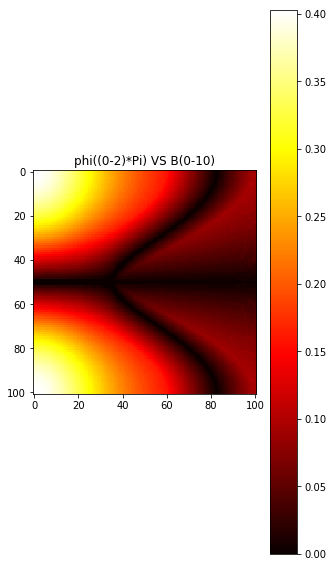

In [25]:
#alR=2.
pp.figure(figsize=(5,10))
pp.title('phi((0-2)*Pi) VS B(0-10)')
pp.imshow(PDgap11,cmap='hot')
pp.colorbar()

PDgap10=PDgap

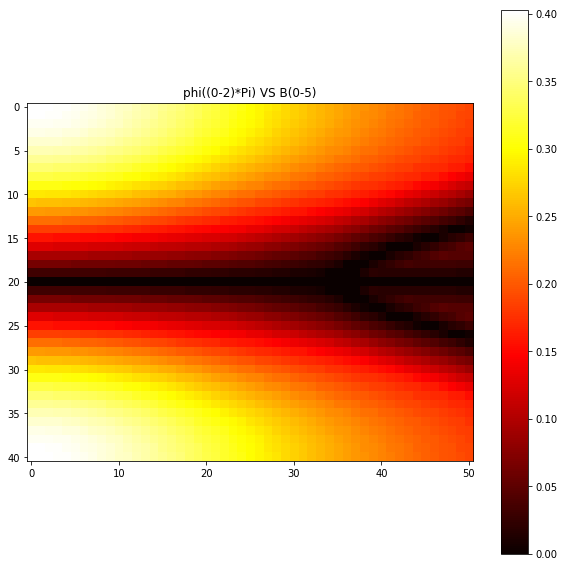

In [13]:
#alR=2.
pp.figure(figsize=(10,10))
pp.title('phi((0-2)*Pi) VS B(0-5)')
pp.imshow(PDgap10,cmap='hot')
pp.colorbar()

PDgap9=PDgap

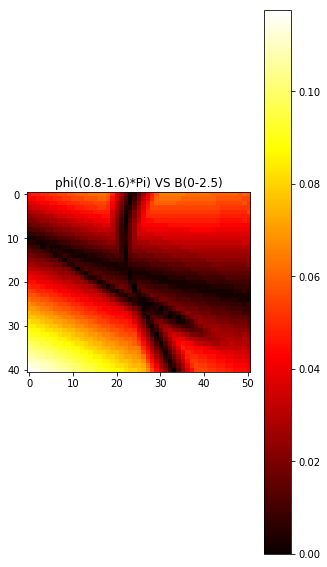

In [25]:
#alR=2.
pp.figure(figsize=(5,10))
pp.title('phi((0.8-1.6)*Pi) VS B(0-2.5)')
pp.imshow(PDgap9,cmap='hot')
pp.colorbar()

PDgap8=PDgap

NameError: name 'PDgap8' is not defined

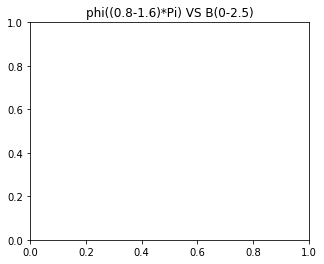

In [12]:
#alR=5.
pp.figure(figsize=(5,4))
pp.title('phi((0.8-1.6)*Pi) VS B(0-2.5)')
pp.imshow(PDgap8,cmap='hot')
pp.colorbar()

PDgap7=PDgap

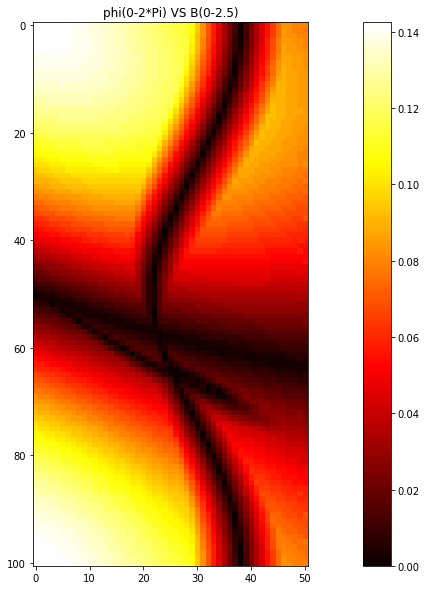

In [8]:
#alR=2.
pp.figure(figsize=(5,10))
pp.title('phi(0-2*Pi) VS B(0-2.5)')
pp.imshow(PDgap7,cmap='hot')
pp.colorbar()

PDgap6=PDgap

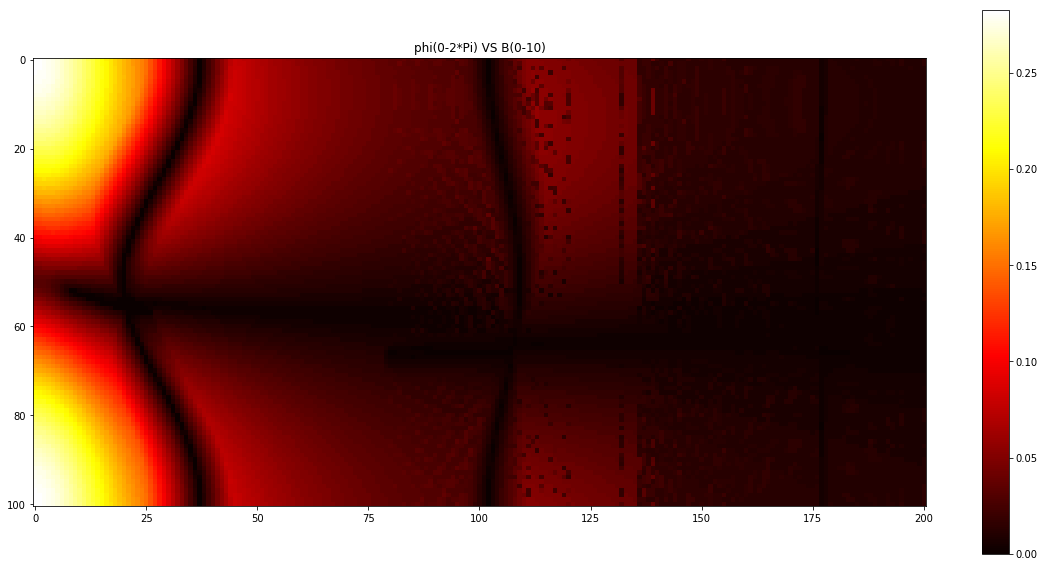

In [127]:
#alR=0.7
pp.figure(figsize=(20,10))
pp.title('phi(0-2*Pi) VS B(0-10)')
pp.imshow(PDgap6,cmap='hot')
pp.colorbar()

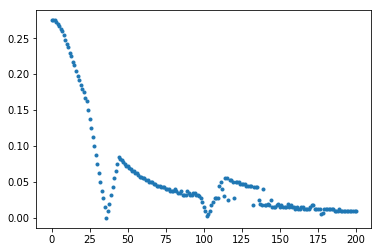

In [128]:
pp.plot(range(len(PDgap6[8])),PDgap6[8],'.')

PDgap5=PDgap

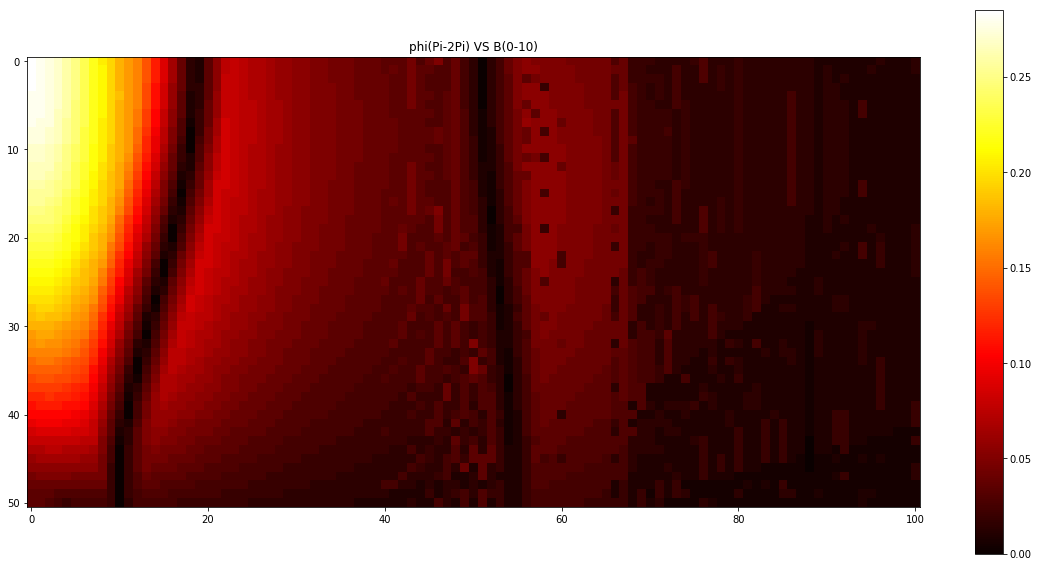

In [110]:
pp.figure(figsize=(20,10))
pp.title('phi(Pi-2Pi) VS B(0-10)')
pp.imshow(PDgap5,cmap='hot')
pp.colorbar()

PDgap4=PDgap

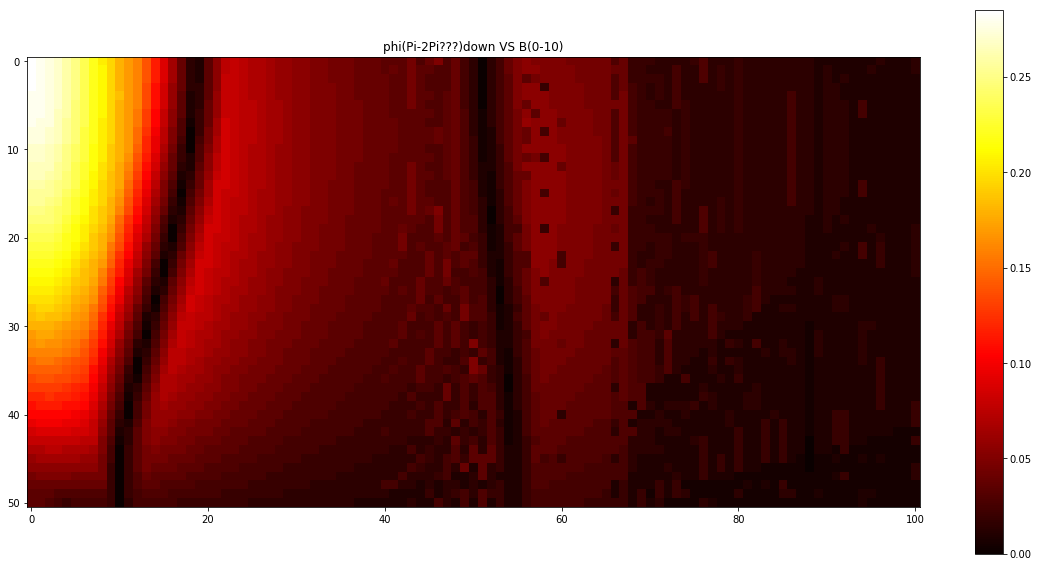

In [111]:
pp.figure(figsize=(20,10))
pp.title('phi(Pi-2Pi???)down VS B(0-10)')
pp.imshow(PDgap4,cmap='hot')
pp.colorbar()

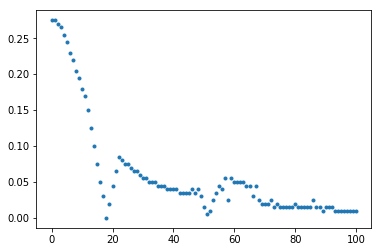

In [88]:
pp.plot(range(len(PDgap4[8])),PDgap4[8],'.')

PDgap3=PDgap

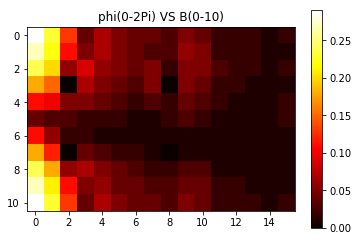

In [71]:
pp.title('phi(0-2Pi) VS B(0-10)')
pp.imshow(PDgap3,cmap='hot')
pp.colorbar()

PDgap2=PDgap

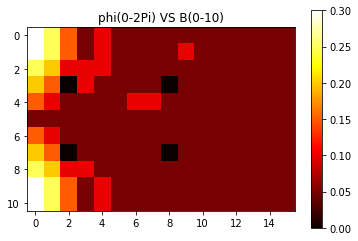

In [68]:
pp.title('phi(0-2Pi) VS B(0-10)')
pp.imshow(PDgap2,cmap='hot')
pp.colorbar()

not PDgap1=PDgap

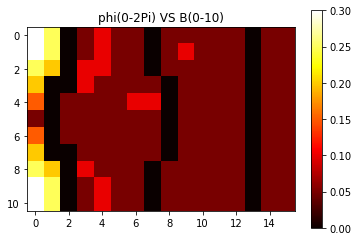

In [65]:
pp.title('phi(0-2Pi) VS B(0-10)')
pp.imshow(PDgap,cmap='hot')
pp.colorbar()